### Important Questions:
1. What is the optimal error?
2. What is the human level error?
3. How much better or worse is the model compared to human level error?

My assumption is that optimal error is zero %, and human level error is close to that. 
But it is likely that the human level error is considerably worse.

In [208]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay


from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate,
    train,
    evaluate_weighted,
    train_weighted,
    EarlyStopper,
)


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [209]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

metric_key = f"{metric_key_unsmoothed}_smoothed"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric
normalized_metric_pct_chg = "normalized_" + metric + "_pct_chg"

In [210]:
start_year = 2006
eval_start_year = 2020 # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

df[normalized_metric_pct_chg] = df.groupby("year")[
    metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)].reset_index(drop=True)
eval_df = df[df["year"] >= eval_start_year].reset_index(drop=True)

In [211]:
train_df[train_df["area_code"] == 13101][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,normalized_unit_price_median_smoothed_pct_chg
15,2007,2.204983e+06,0.227171,2.619291
17,2008,2.197454e+06,0.139858,1.066988
311,2009,2.069647e+06,-0.061378,-0.060949
2019,2010,1.825045e+06,-0.169473,-0.456003
2613,2011,1.620211e+06,-0.217156,-0.780465
3952,2012,1.684720e+06,-0.076888,-0.332538
6417,2013,1.947510e+06,0.202010,1.113350
7669,2014,2.130575e+06,0.264646,1.446387
8304,2015,2.257352e+06,0.159097,0.843063
10500,2016,2.645833e+06,0.241840,1.197871


In [212]:
eval_df[eval_df["area_code"] == 13101][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,normalized_unit_price_median_smoothed_pct_chg
629,2020,3.849920e+06,0.257623,1.115681
1949,2021,4.164547e+06,0.225359,0.829393
3850,2022,4.462737e+06,0.159177,0.495757


In [216]:
idx = 3850
row = eval_df.iloc[idx]
target = row[normalized_metric_pct_chg]
area_code, year = row["area_code"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)


In [217]:
target

0.49575667557701153

In [218]:
columns = [
    metric,
    metric_pct_chg,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
    "total_tax",
    "total_tax_growth",
]

columns_maintained = [
    # "years_since_crisis",
    "migrations_is_available", 
    "taxable_income_is_available", 
    "dwellings_is_available",
    "total_tax_is_available"
]

columns_normalized = [f"{col}_normalized" for col in columns]

train_df["count_scaled"] = train_df["count"].apply(lambda x: 1 + np.log10(x))
eval_df["count_scaled"] = eval_df["count"].apply(lambda x: 1 + np.log10(x))

df = pd.concat([train_df, eval_df])

# more detailed area level normalization would help

In [219]:
columns_normalized_yearly = [f"{col}_normalized_yearly" for col in columns]
for col in columns:
    df[f"{col}_normalized_yearly"] = df.groupby("year")[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# To account for years where the data is not available and all the values are zero. In those situations, the normalized values will be NaN.
df = df.fillna(0)

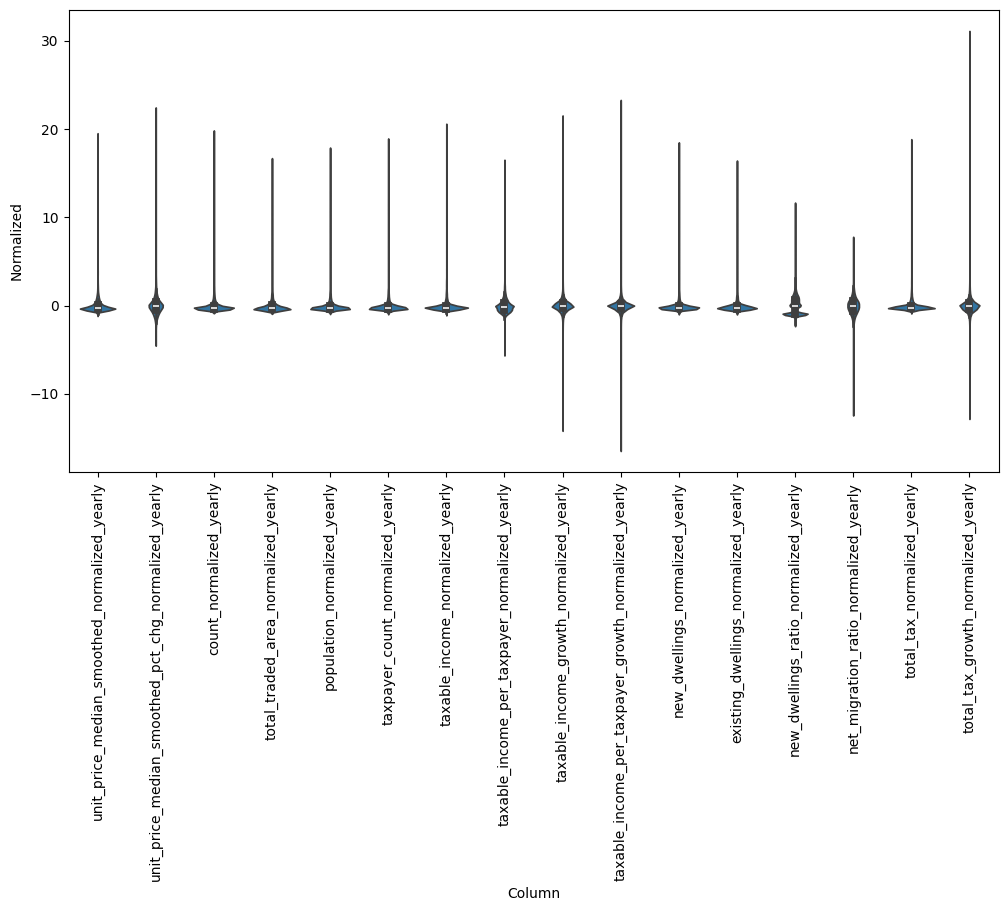

In [220]:
df_std = df[columns_normalized_yearly].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized_yearly].keys(), rotation=90)

In [221]:
feature_columns = [metric_pct_chg] + columns_normalized_yearly + columns_maintained

time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    shift=years_ahead
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (0, 21) (1,) [-0.21269522] [3.11058971]
1 (0, 21) (1,) [-1.03503937] [1.60205999]
2 (0, 21) (1,) [0.59343579] [3.82930377]
3 (0, 21) (1,) [0.79184607] [4.02978947]
0 torch.Size([5, 21]) torch.Size([1]) tensor([-0.2127]) tensor([3.1106])
1 torch.Size([5, 21]) torch.Size([1]) tensor([-1.0350]) tensor([1.6021])
2 torch.Size([5, 21]) torch.Size([1]) tensor([0.5934]) tensor([3.8293])
3 torch.Size([5, 21]) torch.Size([1]) tensor([0.7918]) tensor([4.0298])


In [222]:
BATCH_SIZE = 256

In [223]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18826 entries, 0 to 4092
Data columns (total 43 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   unit_price_median_smoothed_pct_chg                    18826 non-null  float64
 1   unit_price_median_smoothed                            18826 non-null  float64
 2   unit_price_median                                     18826 non-null  float64
 3   year                                                  18826 non-null  int64  
 4   years_since_crisis                                    18826 non-null  int64  
 5   count                                                 18826 non-null  float64
 6   total_traded_area                                     18826 non-null  float64
 7   population                                            18826 non-null  float64
 8   taxpayer_count                                        188

### Building the Transformer Model

In [225]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [226]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [227]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 21]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.699550151824951


In [228]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs = 30

In [229]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear", # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [230]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 8.5822, Eval Loss: 7.8175
Train R^2: -0.0061, Eval R^2: 0.0959
Epoch: 1
Train Loss: 6.7343, Eval Loss: 4.9997
Train R^2: 0.2081, Eval R^2: 0.4337
Epoch: 2
Train Loss: 6.3608, Eval Loss: 4.4103
Train R^2: 0.2536, Eval R^2: 0.5002
Epoch: 3
Train Loss: 5.6909, Eval Loss: 4.1279
Train R^2: 0.3337, Eval R^2: 0.5333
Epoch: 4
Train Loss: 5.1699, Eval Loss: 3.9449
Train R^2: 0.3939, Eval R^2: 0.5526
Epoch: 5
Train Loss: 4.9568, Eval Loss: 3.9313
Train R^2: 0.4190, Eval R^2: 0.5528
Epoch: 6
Train Loss: 4.7824, Eval Loss: 3.9086
Train R^2: 0.4389, Eval R^2: 0.5549
Epoch: 7
Train Loss: 4.6431, Eval Loss: 3.8785
Train R^2: 0.4553, Eval R^2: 0.5585
Epoch: 8
Train Loss: 4.5194, Eval Loss: 3.8380
Train R^2: 0.4699, Eval R^2: 0.5632
Epoch: 9
Train Loss: 4.4015, Eval Loss: 3.8024
Train R^2: 0.4835, Eval R^2: 0.5671
Epoch: 10
Train Loss: 4.2846, Eval Loss: 3.7665
Train R^2: 0.4971, Eval R^2: 0.5711
Epoch: 11
Train Loss: 4.1799, Eval Loss: 3.7438
Train R^2: 0.5091, Eval R^2: 0.5736
E

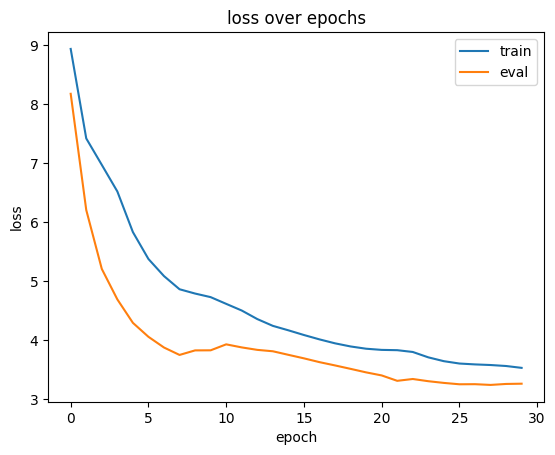

In [67]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

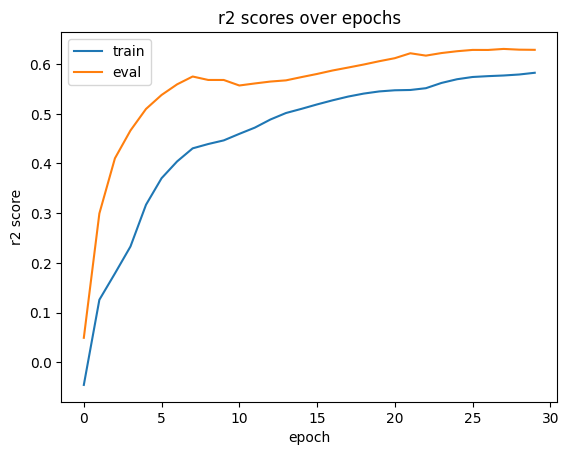

In [68]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [69]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 3.2632
Eval R2: 0.6287


# Packing up the results and sending it to exploration

In [29]:
# To Do: 
# Build function to evaluate individual areas - Done

In [70]:
def predict_return(model, area_code, year):
    area_df = df[(df["year"] == year) & (df["area_code"] == area_code)]

    area_dataset = JapanRETimeSeriesDataset(
        df,
        area_df,
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    )

    area_dataloader = DataLoader(
        area_dataset, batch_size=10, shuffle=False, num_workers=0
    )

    batch = next(iter(area_dataloader))
    
    model.eval()

    output = model(batch["window"].to(device), batch["mask"].to(device))
    return output.item()

In [71]:
years = [2020, 2021, 2022] # saving all predicted years.

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_return(model, row["area_code"], row["year"]), axis=1
)
prediction_df = prediction_df.sort_values(
    by="year", ascending=False
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_smoothed_pct_chg,normalized_unit_price_median_smoothed_pct_chg
4092,2022,34203,-0.584258,-0.040610,-0.198210
3192,2022,10212,-0.759265,-0.236664,-0.879212
3194,2022,7408,0.937860,0.374208,1.242676
3195,2022,27207,-0.348230,-0.161175,-0.616998
3196,2022,13206,0.177946,0.075929,0.206592
...,...,...,...,...,...
919,2020,29453,-0.665711,-0.067494,-0.408549
920,2020,38203,-0.617131,-0.095668,-0.540639
921,2020,26366,0.376726,0.111731,0.431702
922,2020,37201,0.391943,0.188607,0.792115


In [72]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

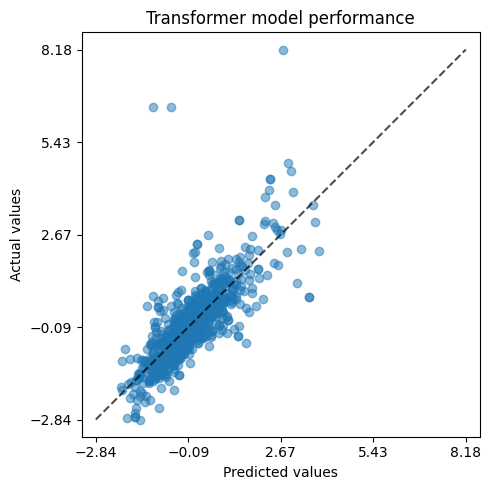

In [99]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

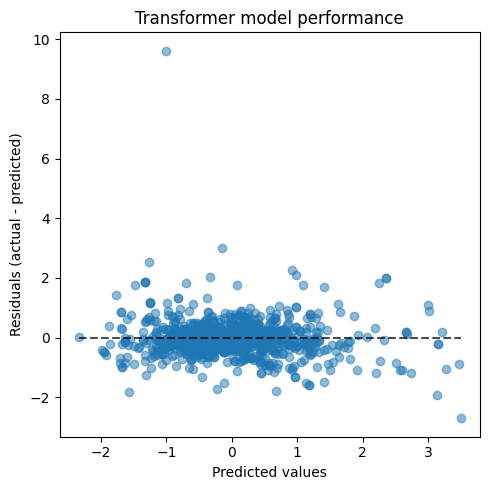

In [102]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()